# Test Uncertainty Propagation (UP) techniques on Linear Freeflyer 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import rc
import time

import sys, os
sys.path.append('../..')
from models.freeflyer_linear import Model
import utils

# viz
import matplotlib.image as mpimg
img = mpimg.imread('figs/random_set_prop.png'); fig = plt.figure(figsize=(14, 6)); plt.imshow(img); plt.axis('off'); plt.show()

<Figure size 1400x600 with 1 Axes>

### Load Model + True Dynamics + Problem + Nominal Trajectory

In [2]:
# model
model = Model()
model.reset()
# problem definition
x_init = np.array([0.4,-0.3,0.0,0,0,0])+1e-6

[freeflyer_linear::__init__] Initializing freeflyer Model 
                             (linear, uncertain mass and inertia).
[freeflyer_linear::reset] resetting mass, J, and deltas.
[freeflyer_linear::reset] resetting mass, J, and deltas.


In [3]:
# nominal traj example
X_nom = np.load('data/Xtraj.npy'); #np.save('data/Xtraj', Xtraj)
U_nom = np.load('data/Utraj.npy'); #np.save('data/Utraj', Utraj)
X_nom.shape

(6, 14)

## Propagate Uncertainty

In [4]:
N_MC = 1000

In [5]:
Xs, Us = model.simulate_batch(x_init, X_nom, U_nom,
                             N_MC = N_MC)
Xs.shape

(1000, 6, 14)

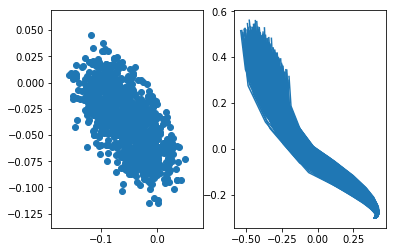

In [6]:
from utils.viz import plot_pts_2d, plot_trajs_2d
k = 10
plt.subplot(1,2,1)
plot_pts_2d(Xs[:,:,k])
plt.subplot(1,2,2)
plot_trajs_2d(Xs)

## Adv. sampling

In [7]:
ms, Js, ws = model.masses_MC, model.Js_MC, model.ws_MC

In [8]:
# compute particles gradient
xks_dmass, xks_dJ, xks_dws = model.Xs_dparams_MC(X_nom, U_nom, Xs, Us)
xks_dmass, xks_dJ, xks_dws = xks_dmass[:,:,k], xks_dJ[:,:,k], xks_dws[:,:,k,:,:]

In [9]:
Xs_k = Xs[:,:,k]
ck   = np.mean(Xs[:,:,k],0) # (6,)
Cs_k = np.repeat(ck[np.newaxis,:], N_MC, axis=0)

In [10]:
# compute cost gradient
Jdist_dXks = (Xs_k-Cs_k).T * (1./ np.linalg.norm(Xs_k-Cs_k, axis=1)).T

In [11]:
Jdist_dws = np.einsum('dM,MdNw->MNw', Jdist_dXks, xks_dws) 
Jdist_dms = np.einsum('dM,Md->M', Jdist_dXks, xks_dmass) 
Jdist_dJs = np.einsum('dM,Md->M', Jdist_dXks, xks_dJ) 

In [12]:
print(np.linalg.norm(ms))
print(np.linalg.norm(Jdist_dms))
print(np.linalg.norm(Js))
print(np.linalg.norm(Jdist_dJs))

455.1994249919853
0.5312088643060524
4.763525446488697
0.002961874679852106


In [13]:
# gradient ascent
ws_worse = ws + 1e-3*Jdist_dws
ms_worse = ms + 1e2*Jdist_dms
Js_worse = Js + 1e2*Jdist_dJs
# clip
for i in range(model.n_x):
    ws_worse[:,:,i] = np.clip(ws_worse[:,:,i], model.w_nom[i]-model.w_deltas[i], 
                                                 model.w_nom[i]+model.w_deltas[i])
ms_worse = np.clip(ms_worse, model.mass_nom-model.mass_deltas, model.mass_nom+model.mass_deltas)
Js_worse = np.clip(Js_worse, model.J_nom   -model.J_deltas,    model.J_nom+model.J_deltas)

In [14]:
# change disturbance i
ws_MC_old = model.ws_MC.copy()
model.ws_MC = ws_worse

In [15]:
# chance masses and inertias
ms_MC_old = model.masses_MC.copy()
model.masses_MC = ms_worse
Js_MC_old   = model.Js_MC.copy()
model.Js_MC = Js_worse
print(np.linalg.norm(ms_MC_old-ms_worse))
print(np.linalg.norm(Js_MC_old-Js_worse))

22.90089418749676
0.2727894654834541


In [16]:
# resimulate
Xs_worse, Us_worse = model.simulate_batch(x_init, X_nom, U_nom,
                             N_MC = N_MC, B_resample = False)

In [17]:
import time
start = time.time()
# model.simulate_batch(x_init, X_nom, U_nom, N_MC=N_MC, B_resample = False)
model.Xs_dparams_MC(X_nom, U_nom, Xs, Us)


end = time.time()
print(end - start)

0.09215044975280762


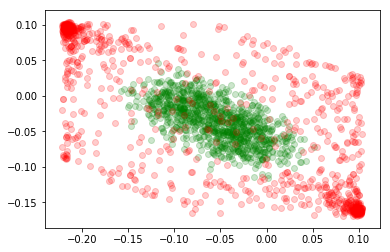

In [18]:
# plot change
# plt.xlim(-0.21,0.11)
# plt.ylim(-0.17,0.11)
plot_pts_2d(Xs[:,:,k],       alpha=0.2, color='g')
plot_pts_2d(Xs_worse[:,:,k], alpha=0.2, color='r')
# plt.scatter(xki[0],       xki[1],       color='g')
# plt.scatter(xki_worse[0], xki_worse[1], color='r')
# plt.arrow(xki[0]+0.15*(xki_worse[0]-xki[0]), xki[1]+0.15*(xki_worse[1]-xki[1]), 
#           0.5*(xki_worse[0]-xki[0]), 0.5*(xki_worse[1]-xki[1]),color="b")
# plt.scatter(xki1[0],       xki1[1],       color='g')
# plt.scatter(xki_worse1[0], xki_worse1[1], color='r')
# plt.arrow(xki1[0]+0.15*(xki_worse1[0]-xki1[0]), xki1[1]+0.15*(xki_worse1[1]-xki1[1]), 
#           0.5*(xki_worse1[0]-xki1[0]), 0.5*(xki_worse1[1]-xki1[1]),color="b")
# plt.scatter(xki2[0],       xki2[1],       color='g')
# plt.scatter(xki_worse2[0], xki_worse2[1], color='r')
# plt.arrow(xki2[0]+0.15*(xki_worse2[0]-xki2[0]), xki2[1]+0.15*(xki_worse2[1]-xki2[1]), 
#           0.5*(xki_worse2[0]-xki2[0]), 0.5*(xki_worse2[1]-xki2[1]),color="b")

In [19]:
from utils.viz import plot_pts_2d, plot_trajs_2d
N_MC = 1000
k            = 10
idx          = [0,1]
n_adv        = 5
vec_Xs_robUP = []


Xs, Us = model.simulate_batch(x_init, X_nom, U_nom,
                         N_MC = N_MC)
Xs_randUP = Xs.copy()
for i in range(n_adv):
    print('i =',i)
    ms, Js, ws = model.masses_MC, model.Js_MC, model.ws_MC
    # compute particles gradient
    xks_dmass, xks_dJ, xks_dws = model.Xs_dparams_MC(X_nom, U_nom, Xs, Us)
    xks_dmass, xks_dJ, xks_dws = xks_dmass[:,:,k], xks_dJ[:,:,k], xks_dws[:,:,k,:,:]
    Xs_k = Xs[:,:,k]
    ck   = np.mean(Xs[:,:,k],0) # (6,)
    Cs_k = np.repeat(ck[np.newaxis,:], N_MC, axis=0)
    # compute cost gradient
    Jdist_dXks = (Xs_k-Cs_k).T * (1./ np.linalg.norm(Xs_k-Cs_k, axis=1)).T
    Jdist_dws  = np.einsum('dM,MdNw->MNw', Jdist_dXks, xks_dws) 
    Jdist_dms  = np.einsum('dM,Md->M', Jdist_dXks, xks_dmass) 
    Jdist_dJs  = np.einsum('dM,Md->M', Jdist_dXks, xks_dJ) 
    # gradient ascent
    ws_worse = ws + 1e-3*Jdist_dws
    ms_worse = ms + 1e2*Jdist_dms
    Js_worse = Js + 1e2*Jdist_dJs
    # clip
    for i in range(model.n_x):
        ws_worse[:,:,i] = np.clip(ws_worse[:,:,i], model.w_nom[i]-model.w_deltas[i], 
                                                 model.w_nom[i]+model.w_deltas[i])
    ms_worse = np.clip(ms_worse, model.mass_nom-model.mass_deltas, model.mass_nom+model.mass_deltas)
    Js_worse = np.clip(Js_worse, model.J_nom   -model.J_deltas,    model.J_nom+model.J_deltas)
    # change disturbance i
    ws_MC_old = model.ws_MC.copy()
    model.ws_MC = ws_worse
    # chance masses and inertias
    ms_MC_old = model.masses_MC.copy()
    model.masses_MC = ms_worse
    Js_MC_old   = model.Js_MC.copy()
    model.Js_MC = Js_worse
    # resimulate
    Xs, Us = model.simulate_batch(x_init, X_nom, U_nom,
                         N_MC = N_MC, B_resample = False)
    vec_Xs_robUP.append(Xs)

i = 0
i = 1
i = 2
i = 3
i = 4


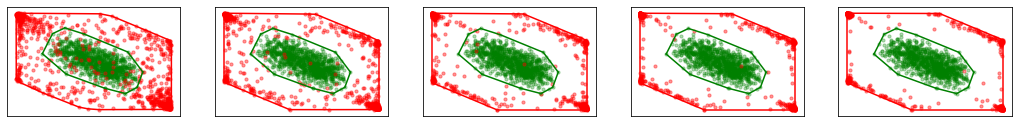

In [20]:
from scipy.spatial import ConvexHull

plt.figure(figsize=[18,2])
for i in range(n_adv):
    plt.subplot(1,n_adv,i+1)

    plot_pts_2d(Xs_randUP[:,:,k], idx=idx, color='g', alpha=0.3, markerwidth=10)
    hull = ConvexHull(Xs_randUP[:,idx,k])
    for simplex in hull.simplices:
        plt.plot(Xs_randUP[simplex,idx[0],k], Xs_randUP[simplex,idx[1],k], 'g-')

    Xs_robUP = vec_Xs_robUP[i]
    plot_pts_2d(Xs_robUP[:,:,k], idx=idx, color='r', alpha=0.4, markerwidth=10)
    hull = ConvexHull(Xs_robUP[:,idx,k])
    for simplex in hull.simplices:
        plt.plot(Xs_robUP[simplex,idx[0],k], Xs_robUP[simplex,idx[1],k], 'r-')

    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

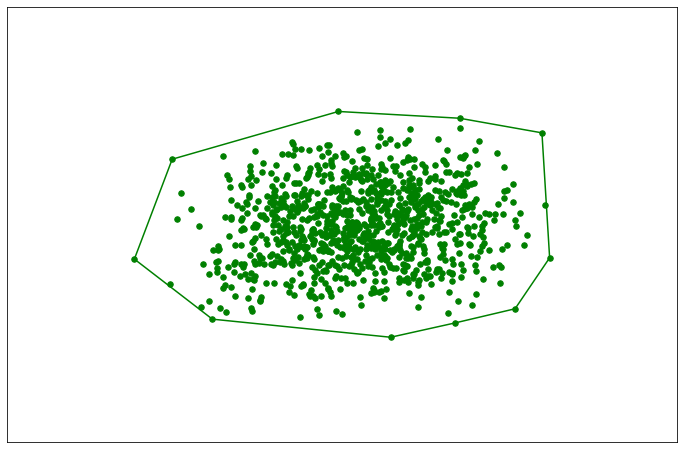

In [28]:
# Slides figure 
k= 3

plt.figure(figsize=[12,8])
# for i in range(n_adv):

plot_pts_2d(Xs_randUP[:,:,k], idx=idx, color='g', alpha=1, markerwidth=30)
hull = ConvexHull(Xs_randUP[:,idx,k])
for simplex in hull.simplices:
    plt.plot(Xs_randUP[simplex,idx[0],k], Xs_randUP[simplex,idx[1],k], 'g-')

#     Xs_robUP = vec_Xs_robUP[i]
#     plot_pts_2d(Xs_robUP[:,:,k], idx=idx, color='r', alpha=0.4, markerwidth=10)
#     hull = ConvexHull(Xs_robUP[:,idx,k])
#     for simplex in hull.simplices:
#         plt.plot(Xs_robUP[simplex,idx[0],k], Xs_robUP[simplex,idx[1],k], 'r-')

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)